In [24]:
import cvxpy as cp
import numpy as np
import warnings
import sys
from IPython.core.interactiveshell import InteractiveShell
import torch
import torch.optim as optim
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt

import time
from tqdm import tqdm

np.random.seed(42)
torch.manual_seed(42)

warnings.filterwarnings("ignore")
InteractiveShell.ast_node_interactivity = "all"
sys.path.insert(1,'E:\\User\\Stevens\\Spring 2024\\PTO - Fairness\\myGit\\myUtils')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

import pandas as pd
sys.path.insert(0, 'E:\\User\\Stevens\\Code\\The Paper\\algorithm')

from myutil import *
from features import *
df = pd.read_csv('E:\\User\\Stevens\\Code\\The Paper\\data\\data.csv')

columns_to_keep = [
    'risk_score_t', 'program_enrolled_t', 'cost_t', 'cost_avoidable_t', 'race', 'dem_female', 'gagne_sum_tm1', 'gagne_sum_t', 
    'risk_score_percentile', 'screening_eligible', 'avoidable_cost_mapped', 'propensity_score', 'g_binary', 
    'g_continuous', 'utility_binary', 'utility_continuous'
]
# for race 0 is white, 1 is black
df_stat = df[columns_to_keep]
df_feature = df[[col for col in df.columns if col not in columns_to_keep]]


all_features = df[get_all_features(df)]
risk_score = df['risk_score_t']
g_factor = df['g_continuous']
decision = df['propensity_score']

feats = all_features.values
risk = risk_score.values
cost = np.ones(risk.shape)
gainF = g_factor.values
decision = decision.values

alpha = 0.5
Q = 1e2

data = feats, risk, cost, gainF, decision

cuda


In [25]:
class optModel:
    """
    This is a class for optimization models.
    """

    def __init__(self, feats, risk, cost, gainF, decision, alpha=alpha, Q = Q):
        self.feats, self.risk, self.cost, self.gainF, self.decision = feats, risk, cost, gainF, decision
        self.alpha = alpha
        self.Q = Q

    def setObj(self, risk, cost):

        if self.alpha == 1:
            self.objective = cp.sum(cp.log(cp.multiply(cp.multiply(self.gainF, risk), self.d)))
        else:
            self.objective = cp.sum(cp.multiply(cp.multiply(self.gainF, risk), self.d)) ** (1 - alpha) / (1 - alpha)
        
        self.constraints = [
            self.d >= 0,
            self.d <= 1,
            cp.sum(cp.multiply(cost, self.d)) <= self.Q
        ]
        self.problem = cp.Problem(cp.Maximize(self.objective), self.constraints)
    
    def solve(self):

        self.d = cp.Variable(self.decision.shape, nonneg=True)
        self.setObj(self.risk, self.cost)
        self.problem.solve(solver=cp.SCS, max_iters=4000)
        opt_sol = self.d.value
        opt_val = self.problem.value

        return opt_sol, opt_val

In [87]:
class optDataset(Dataset):
    """
    This class is Torch Dataset class for optimization problems.
    """

    def __init__(self, features, costs, risks, gains, decisions, Q=Q, alpha=alpha, closed=False):
        """
        A method to create an optDataset from optModel

        Args:
            features (np.ndarray): features
            costs (np.ndarray): costs
            risks (np.ndarray): risk factors
            gains (np.ndarray): gain factors
            decisions (np.ndarray): initial decision variables
            Q (float): budget
            alpha (float): alpha of the objective function
            closed (bool): solving the problem in closed form
        """
        self.feats = features
        self.costs = costs
        self.risks = risks
        self.gains = gains
        self.decisions = decisions
        self.Q = Q
        self.alpha = alpha
        self.closed = closed

        self.sols, self.objs = self._get_solutions()



    def _get_solutions(self):
        """
        A method to get the solutions of the optimization problem.
        """
        opt_solutions = []
        opt_objectives = []

        sol, obj = self._solve(self.risks, self.costs, self.gains, self.decisions)
        opt_solutions.append(sol)
        opt_objectives.append([obj])

        return np.array(opt_solutions), np.array(opt_objectives)

    def _solve(self, risk, cost, gain, decision):
        """
        A method to solve the optimization problem to get an optimal solution with given inputs.

        Args:
            risk (np.ndarray): risk factors
            cost (np.ndarray): costs
            gain (np.ndarray): gain factors
            decision (np.ndarray): initial decision variables

        Returns:
            tuple: optimal solution (np.ndarray), objective value (float)
        """
        model = optModel(self.feats, risk, cost, gain, decision, alpha=self.alpha, Q=self.Q)
        if self.closed:
            return None
        else:
            return model.solve()

    def __len__(self):
        return len(self.costs)

    def __getitem__(self):
        """
        A method to retrieve data.

        Args:
            index (int): data index.

        Returns:
            tuple: data features (torch.tensor), costs (torch.tensor), risks (torch.tensor),
                   gains (torch.tensor), decisions (torch.tensor), optimal solutions (torch.tensor),
                   and objective values (torch.tensor).
        """
        
        return (
            torch.FloatTensor(self.feats),  # x 
            torch.FloatTensor(self.costs),  # costs
            torch.FloatTensor(self.risks),  # risks
            torch.FloatTensor(self.gains),  # gains
            torch.FloatTensor(self.decisions),  # initial decision variables
            torch.FloatTensor(self.sols),  # optimal solution
            torch.FloatTensor(self.objs),  # objective value
        )


In [88]:
class LinearRegressionModel(nn.Module):
    def __init__(self, num_items, num_features):
        super(LinearRegressionModel, self).__init__()
        self.num_items = num_items
        self.num_features = num_features
        self.linears = nn.ModuleList([nn.Linear(num_features, 1) for _ in range(num_items)])

    def forward(self, x):
        outputs = []
        for i in range(self.num_items):
            outputs.append(torch.sigmoid(self.linears[i](x[:, i, :])))
        return torch.cat(outputs, dim=1)

In [89]:
def objValue(d, r, alpha=2):
    """
    A function to calculate objective value
    """
    if alpha == 1:
        return np.sum(np.log(np.multiply(r, d)))
    else:
        return np.sum(np.power(np.multiply(r, d), 1 - alpha)) / (1 - alpha)

def regret(predmodel, optmodel, dataloader):
    """
    A function to evaluate model performance with normalized true regret

    Args:
        predmodel (nn): a regression neural network for cost prediction
        optmodel (optModel): an optimization model
        dataloader (DataLoader): Torch dataloader from optDataset

    Returns:
        float: true regret loss
    """
    # evaluate
    predmodel.eval()
    loss = 0
    optsum = 0
    # load data
    for data in dataloader:
        feats, costs, risks, gains, decisions, sols, objs = data
        # cuda
        if next(predmodel.parameters()).is_cuda:
            feats, costs, risks, gains, decisions, sols, objs = feats.cuda(), costs.cuda(), risks.cuda(), gains.cuda(), decisions.cuda(), sols.cuda(), objs.cuda()
        # predict
        with torch.no_grad(): # no grad
            rp = predmodel(feats).to("cpu").detach().numpy()
        # solve
        for j in range(rp.shape[0]):
            # accumulate loss
            loss += calRegret(optModel,)
        optsum += abs(z).sum().item()
    # turn back train model
    predmodel.train()
    # normalized
    return loss / (optsum + 1e-7)


def calRegret(optmodel, feats, pred_risk, true_risk, cost, true_obj):
    """
    A function to calculate normalized true regret for a batch

    Args:
        optmodel (optModel): optimization model
        pred_cost (torch.tensor): predicted costs
        true_cost (torch.tensor): true costs
        true_obj (torch.tensor): true optimal objective values

    Returns:predmodel
        float: true regret losses
    """
    # opt sol for pred cost
    model = optmodel(feats, pred_risk, cost, gainF, decision)
    sol, _ = model.solve()
    # obj with true cost
    obj = objValue(sol, true_risk, alpha=2)
    # loss
    loss = true_obj - obj
    return loss

In [90]:
def visLearningCurve(loss_log, loss_log_regret, mse_loss_log):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))

    # Plot original loss log
    ax1.plot(loss_log, color="c", lw=2)
    ax1.tick_params(axis="both", which="major", labelsize=12)
    ax1.set_xlabel("Iters", fontsize=16)
    ax1.set_ylabel("Loss", fontsize=16)
    ax1.set_title("Learning Curve (Training Loss)", fontsize=16)

    # Plot regret log
    ax2.plot(loss_log_regret, color="royalblue", ls="--", alpha=0.7, lw=2)
    ax2.tick_params(axis="both", which="major", labelsize=12)
    ax2.set_xlabel("Epochs", fontsize=16)
    ax2.set_ylabel("Regret", fontsize=16)
    ax2.set_title("Learning Curve (Test Regret)", fontsize=16)

    # Plot new MSE loss log
    ax3.plot(mse_loss_log, color="orange", lw=2)
    ax3.tick_params(axis="both", which="major", labelsize=12)
    ax3.set_xlabel("Iters", fontsize=16)
    ax3.set_ylabel("MSE Loss", fontsize=16)
    ax3.set_title("Learning Curve (MSE Loss)", fontsize=16)

    plt.tight_layout()
    plt.show()

In [91]:
optmodel = optModel(feats, risk, cost, gainF, decision, alpha=alpha, Q=Q)

In [92]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
feats_train, feats_test, risk_train, risk_test, cost_train, cost_test, gainF_train, gainF_test, decision_train, decision_test = train_test_split(
    feats, risk, cost, gainF, decision, test_size=0.2, random_state=42
)

In [93]:
# Create datasets and dataloaders
dataset_train = optDataset(feats_train, cost_train, risk_train, gainF_train, decision_train, Q=Q, alpha=alpha)
dataset_test = optDataset(feats_test, cost_test, risk_test, gainF_test, decision_test, Q=Q, alpha=alpha)

batch_size = 32
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

# 2 Stage


In [95]:
def trainModel(predmodel, loss_func, num_epochs=10, lr=1e-2):
    optimizer = torch.optim.Adam(predmodel.parameters(), lr=lr)
    predmodel.train()
    loss_log = []
    loss_log_regret = [regret(predmodel, optmodel, loader_test)]
    elapsed = 0

    for epoch in range(num_epochs):
        tick = time.time()
        for i, data in enumerate(loader_train):
            feats, costs, risks, gains, decisions, sols, objs = data
            if torch.cuda.is_available():
                feats, costs, risks, gains, decisions, sols, objs = feats.cuda(), costs.cuda(), risks.cuda(), gains.cuda(), decisions.cuda(), sols.cuda(), objs.cuda()
            optimizer.zero_grad()
            pred_risk = predmodel(feats)
            
            # loss = loss_func(rp, r) if using torch.nn.MSELoss
            loss = loss_func(pred_risk, risks)

            loss.backward()
            optimizer.step()

            tock = time.time()
            elapsed += tock - tick
            loss_log.append(loss.item())

        regret_loss = regret(predmodel, optmodel, loader_test)
        loss_log_regret.append(regret_loss)
        print("Epoch {:2},  Loss: {:9.4f},  Regret: {:7.4f}%".format(epoch + 1, loss.item(), regret_loss * 100))
    predmodel.eval()
    print("Total Elapsed Time: {:.2f} Sec.".format(elapsed))
    return loss_log, loss_log_regret


In [103]:

# Set up the model, optimizer, and MSE loss
optmodel = optModel
model = LinearRegressionModel(feats.shape[1], feats.shape[0]).to(device)
criterion = nn.MSELoss()

# Run the training
loss_log, loss_log_regret = trainModel(model, criterion, num_epochs=10, lr=1e-2)


TypeError: optDataset.__getitem__() takes 1 positional argument but 2 were given

## The Pertubed Gradient Regret Loss

In [106]:
# Define Pertubed Regret Loss
from torch.autograd import Function

class RegretLossFunction(Function):
    @staticmethod
    def forward(ctx, optmodel, cost, pred_r, true_r, true_obj, Q, alpha):
        batch_size = pred_r.size(0)
        losses = torch.zeros(batch_size, device=pred_r.device)
        
        pred_r_np = pred_r.detach().cpu().numpy()
        true_r_np = true_r.detach().cpu().numpy()
        cost_np = cost.detach().cpu().numpy()
        
        for i in range(batch_size):
            # opt sol for pred cost
            model = optmodel(pred_r_np[i], cost_np[i], Q, alpha=alpha)
            sol, _ = model.solve()
            # obj with true cost
            obj = objValue(sol, true_r_np[i], alpha=alpha)

            losses[i] = true_obj[i] - obj
        
        # Store necessary tensors for backward pass
        ctx.save_for_backward(pred_r, true_r, cost, true_obj)
        ctx.optmodel = optmodel
        ctx.Q = Q
        ctx.alpha = alpha
        ctx.losses = losses


        return losses.mean().to(pred_r.device)

    @staticmethod
    def backward(ctx, grad_output):

        pred_r, true_r, cost, true_obj = ctx.saved_tensors
        optmodel = ctx.optmodel
        Q = ctx.Q
        alpha = ctx.alpha

        batch_size = pred_r.size(0)
        grad_pred_r = torch.zeros_like(pred_r)
        
        epsilon = 1e-5

        for i in range(batch_size):
            pred_r_np = pred_r[i].detach().cpu().numpy()
            cost_np = cost[i].detach().cpu().numpy()
            true_r_np = true_r[i].detach().cpu().numpy()
            
            gradient = np.zeros_like(pred_r_np)
            for j in range(pred_r_np.size):
                perturbed_pred_r = np.copy(pred_r_np)
                perturbed_pred_r[j] += epsilon
                
                # Compute loss with perturbed pred_r
                model = optmodel(perturbed_pred_r, cost_np, Q, alpha=alpha)
                sol, _ = model.solve()
                obj = objValue(sol, true_r_np, alpha=alpha)
                loss_perturbed = true_obj[i] - obj

                print(sol)
                print(loss_perturbed, ctx.losses[i].item())
                
                # Finite difference approximation
                gradient[j] = (loss_perturbed - ctx.losses[i].item()) / epsilon
            
            grad_pred_r[i] = torch.tensor(gradient, device=pred_r.device)
            print(grad_pred_r[i])
        
        grad_pred_r = grad_output.view(-1, 1) * grad_pred_r

        

        return None, None, grad_pred_r, None, None, None, None

class RegretLoss(nn.Module):
    def __init__(self, optmodel, Q, alpha=alpha):
        super(RegretLoss, self).__init__()
        self.optmodel = optmodel
        self.Q = Q
        self.alpha = alpha

    def forward(self, pred_r, true_r, cost, true_obj):
        return RegretLossFunction.apply(self.optmodel, cost, pred_r, true_r, true_obj, self.Q, self.alpha)


In [107]:
def trainModel(predmodel, loss_func, num_epochs=3, lr=1e-2):
    optimizer = torch.optim.Adam(predmodel.parameters(), lr=lr)
    mse_loss_func = nn.MSELoss()  # Fixed MSE loss metric
    predmodel.train()
    
    loss_log = []
    loss_log_regret = [regret(predmodel, optmodel, loader_test)]
    mse_loss_log = []  # New MSE loss log
    elapsed = 0

    for epoch in range(num_epochs):
        tick = time.time()
        for i, data in enumerate(loader_train):
            x, c, r, d, z = data
            if torch.cuda.is_available():
                x, c, r, d, z = x.cuda(), c.cuda(), r.cuda(), d.cuda(), z.cuda()

            optimizer.zero_grad()
            rp = predmodel(x)  # Forward pass

            # Compute the regret loss (original loss)
            loss = loss_func(rp, r, c, z)
            # Compute MSE loss (new fixed metric)
            mse_loss = mse_loss_func(rp, r)

            loss.backward()
            optimizer.step()

            tock = time.time()
            elapsed += tock - tick
            loss_log.append(loss.item())
            mse_loss_log.append(mse_loss.item())  # Log the MSE loss

        # Compute and log the regret loss after each epoch
        regret_loss = regret(predmodel, optmodel, loader_test)
        loss_log_regret.append(regret_loss)
        print(f"Epoch {epoch + 1:2},  Loss: {loss.item():9.4f},  MSE: {mse_loss.item():7.4f},  Regret: {regret_loss * 100:7.4f}%")

    print(f"Total Elapsed Time: {elapsed:.2f} Sec.")
    return loss_log, loss_log_regret, mse_loss_log  # Return MSE loss log as well

## E2E using solver on regret loss with pertubed gradient

In [108]:
# import numpy as np

# loss_values = [0.2312, 0.2183, 0.2380, 0.2623, 0.2497, 0.1429, 0.2543, 0.2260, 0.2374, 0.2304]
# mse_values = [0.0396, 0.0484, 0.0448, 0.0495, 0.0451, 0.0346, 0.0442, 0.0452, 0.0407, 0.0474]
# regret_values = [1.7309, 1.7168, 1.6986, 1.7296, 1.7002, 1.6976, 1.7029, 1.6963, 1.7042, 1.6982]

# mean_loss = np.mean(loss_values)
# mean_mse = np.mean(mse_values)
# mean_regret = np.mean(regret_values)

# std_loss = np.std(loss_values)
# std_mse = np.std(mse_values)
# std_regret = np.std(regret_values)

# mean_loss, mean_mse, mean_regret, std_loss, std_mse, std_regret

In [ ]:
optmodel = optModel
model = LinearRegressionModel(num_items, num_features).to(device)
# criterion = nn.MSELoss()
criterion = RegretLoss(optModel,Q)

# Run the training
loss_log, loss_log_regret, mse_loss_log = trainModel(model, criterion, num_epochs=3, lr=1e-2)

# Visualize the learning curves
visLearningCurve(loss_log, loss_log_regret, mse_loss_log)

## E2E using closed-form solution on regret loss with pertubed gradient

In [87]:
import statistics

loss_values = [0.1625, 0.2404, 0.1875, 0.2767, 0.2393, 0.2379, 0.2904, 0.3745, 0.2042, 0.2371]
mse_values = [0.0492, 0.0600, 0.0452, 0.0444, 0.0480, 0.0473, 0.0533, 0.0555, 0.0409, 0.0445]
regret_values = [1.7029, 1.7028, 1.7214, 1.7069, 1.7231, 1.7075, 1.7049, 1.7123, 1.6989, 1.7039]

mean_loss = statistics.mean(loss_values)
mean_mse = statistics.mean(mse_values)
mean_regret = statistics.mean(regret_values)

mean_loss, mean_mse, mean_regret

(0.24505, 0.04883, 1.70846)

In [88]:
import numpy as np

# Given values
loss_values_new = [0.1625, 0.2404, 0.1875, 0.2767, 0.2393, 0.2379, 0.2904, 0.3745, 0.2042, 0.2371]
mse_values_new = [0.0492, 0.0600, 0.0452, 0.0444, 0.0480, 0.0473, 0.0533, 0.0555, 0.0409, 0.0445]
regret_values_new = [1.7029, 1.7028, 1.7214, 1.7069, 1.7231, 1.7075, 1.7049, 1.7123, 1.6989, 1.7039]

# Calculate mean and standard deviation
mean_loss_new = np.mean(loss_values_new)
mean_mse_new = np.mean(mse_values_new)
mean_regret_new = np.mean(regret_values_new)

std_loss_new = np.std(loss_values_new)
std_mse_new = np.std(mse_values_new)
std_regret_new = np.std(regret_values_new)

mean_loss_new, std_loss_new, mean_mse_new, std_mse_new, mean_regret_new, std_regret_new

(0.24505,
 0.05637365075990732,
 0.04883,
 0.005539323063335447,
 1.70846,
 0.007666055048067414)

[4.335358  4.319422  6.398665  4.9328723 4.03288  ]
[4.3354144 4.3193665 6.398665  4.9328723 4.03288  ]
[4.3354087 4.319416  6.398584  4.9328656 4.032874 ]
[4.335414  4.3194213 6.398664  4.932806  4.0328794]
[4.3354163 4.319424  6.398668  4.9328747 4.032828 ]
tensor([ 0.0238,  0.1431,  0.0119, -0.1907,  0.0238], device='cuda:0')
[4.6135154 5.715087  4.309619  4.032482  4.297931 ]
[4.6135817 5.714998  4.3096027 4.032467  4.2979145]
[4.6135798 5.7150626 4.3095613 4.032465  4.2979126]
[4.6135783 5.715061  4.3095994 4.0324326 4.2979116]
[4.6135798 5.7150626 4.3096004 4.032465  4.297874 ]
tensor([-0.0715, -0.1192,  0.2146, -0.0477, -0.1192], device='cuda:0')
[2.065435  1.8644063 2.3044138 2.7349834 2.412305 ]
[2.06546   1.8643857 2.3044121 2.7349815 2.4123034]
[2.065458  1.8644034 2.30439   2.734979  2.412301 ]
[2.0654597 1.8644049 2.304412  2.7349477 2.412303 ]
[2.065465  1.8644097 2.3044178 2.7349885 2.412267 ]
tensor([-0.0477, -0.3338,  0.3815,  0.2384, -0.1431], device='cuda:0')
[4.2590

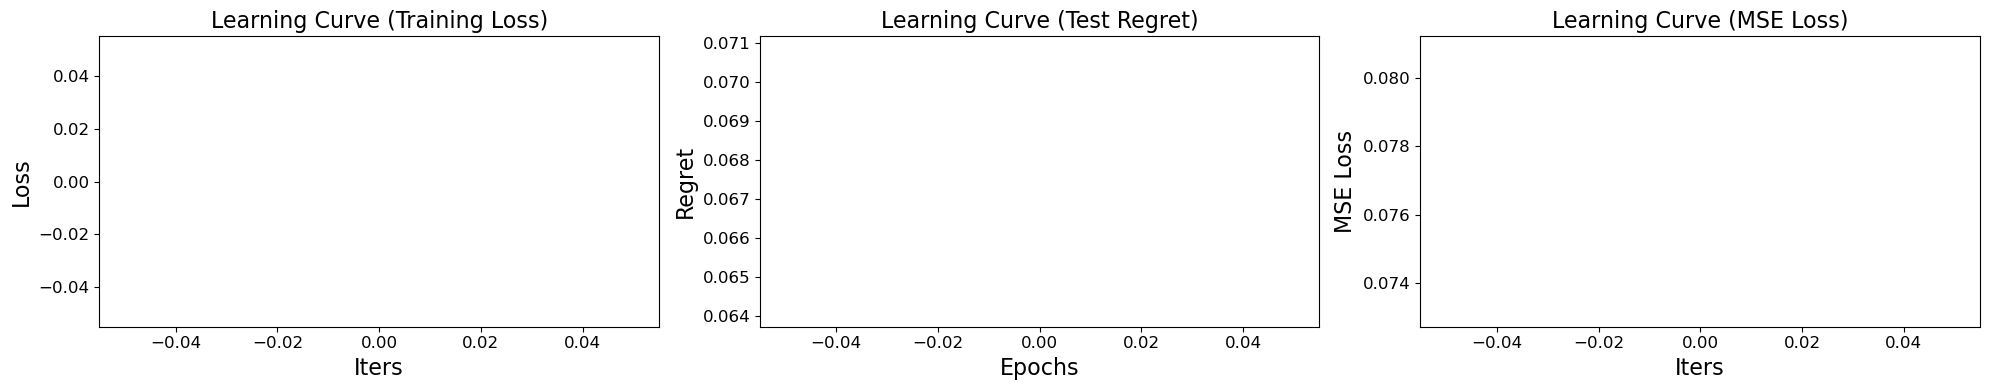

In [89]:
optmodel = optModelClosed
model = LinearRegressionModel(num_items, num_features).to(device)
# criterion = nn.MSELoss()
criterion = RegretLoss(optModelClosed,Q)

# Run the training
loss_log, loss_log_regret, mse_loss_log = trainModel(model, criterion, num_epochs=10, lr=1e-2)

# Visualize the learning curves
visLearningCurve(loss_log, loss_log_regret, mse_loss_log)

## 2-Stage with MSELoss

- Epoch  1,  Loss:    0.0448,  Regret:  1.7459% 
- Epoch  2,  Loss:    0.0394,  Regret:  1.7291%
- Epoch  3,  Loss:    0.0474,  Regret:  1.7376%
- Epoch  4,  Loss:    0.0424,  Regret:  1.7295%
- Epoch  5,  Loss:    0.0405,  Regret:  1.7173%
- Epoch  6,  Loss:    0.0403,  Regret:  1.7311%
- Epoch  7,  Loss:    0.0439,  Regret:  1.7218%
- Epoch  8,  Loss:    0.0412,  Regret:  1.7435%
- Epoch  9,  Loss:    0.0428,  Regret:  1.7452%
- Epoch 10,  Loss:    0.0419,  Regret:  1.7397%
- Total Elapsed Time: 43.66 Sec.

In [90]:
# simply MSE training 
def trainModel(predmodel, loss_func, num_epochs=10, lr=1e-2):
    optimizer = torch.optim.Adam(predmodel.parameters(), lr=lr)
    predmodel.train()
    loss_log = []
    loss_log_regret = [regret(predmodel, optmodel, loader_test)]
    elapsed = 0

    for epoch in range(num_epochs):
        tick = time.time()
        for i, data in enumerate(loader_train):
            x, c, r, d, z = data
            if torch.cuda.is_available():
                x, c, r, d, z = x.cuda(), c.cuda(), r.cuda(), d.cuda(), z.cuda()

            optimizer.zero_grad()
            rp = predmodel(x)
            
            # loss = loss_func(rp, r) if using torch.nn.MSELoss
            loss = loss_func(rp, r)

            loss.backward()
            optimizer.step()

            tock = time.time()
            elapsed += tock - tick
            loss_log.append(loss.item())

        regret_loss = regret(predmodel, optmodel, loader_test)
        loss_log_regret.append(regret_loss)
        print("Epoch {:2},  Loss: {:9.4f},  Regret: {:7.4f}%".format(epoch + 1, loss.item(), regret_loss * 100))
    predmodel.eval()
    print("Total Elapsed Time: {:.2f} Sec.".format(elapsed))
    return loss_log, loss_log_regret

# Define the visualization function
def visLearningCurve(loss_log, loss_log_regret):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

    ax1.plot(loss_log, color="c", lw=2)
    ax1.tick_params(axis="both", which="major", labelsize=12)
    ax1.set_xlabel("Iters", fontsize=16)
    ax1.set_ylabel("Loss", fontsize=16)
    ax1.set_title("Learning Curve on Training Set", fontsize=16)

    ax2.plot(loss_log_regret, color="royalblue", ls="--", alpha=0.7, lw=2)
    ax2.set_xticks(range(0, len(loss_log_regret), 2))
    ax2.tick_params(axis="both", which="major", labelsize=12)
    ax2.set_ylim(0, 0.03)
    ax2.set_xlabel("Epochs", fontsize=16)
    ax2.set_ylabel("Regret", fontsize=16)
    ax2.set_title("Learning Curve on Test Set", fontsize=16)

    plt.show()

In [91]:
def trainModel(predmodel, loss_func, num_epochs=10, lr=1e-2):
    optimizer = torch.optim.Adam(predmodel.parameters(), lr=lr)
    mse_loss_func = nn.MSELoss()  # Fixed MSE loss metric
    predmodel.train()
    
    loss_log = []
    loss_log_regret = [regret(predmodel, optmodel, loader_test)]
    mse_loss_log = []  # New MSE loss log
    elapsed = 0

    for epoch in range(num_epochs):
        tick = time.time()
        for i, data in enumerate(loader_train):
            x, c, r, d, z = data
            if torch.cuda.is_available():
                x, c, r, d, z = x.cuda(), c.cuda(), r.cuda(), d.cuda(), z.cuda()

            optimizer.zero_grad()
            rp = predmodel(x)  # Forward pass

            # Compute the regret loss (original loss)
            loss = loss_func(rp, r, c, z)
            # Compute MSE loss (new fixed metric)
            mse_loss = mse_loss_func(rp, r)

            mse_loss.backward()
            optimizer.step()

            tock = time.time()
            elapsed += tock - tick
            loss_log.append(loss.item())
            mse_loss_log.append(mse_loss.item())  # Log the MSE loss

        # Compute and log the regret loss after each epoch
        regret_loss = regret(predmodel, optmodel, loader_test)
        loss_log_regret.append(regret_loss)
        print(f"Epoch {epoch + 1:2},  Loss: {loss.item():9.4f},  MSE: {mse_loss.item():7.4f},  Regret: {regret_loss * 100:7.4f}%")

    print(f"Total Elapsed Time: {elapsed:.2f} Sec.")
    return loss_log, loss_log_regret, mse_loss_log  # Return MSE loss log as well

In [92]:
def visLearningCurve(loss_log, loss_log_regret, mse_loss_log):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))

    # Plot original loss log
    ax1.plot(loss_log, color="c", lw=2)
    ax1.tick_params(axis="both", which="major", labelsize=12)
    ax1.set_xlabel("Iters", fontsize=16)
    ax1.set_ylabel("Loss", fontsize=16)
    ax1.set_title("Learning Curve (Training Loss)", fontsize=16)

    # Plot regret log
    ax2.plot(loss_log_regret, color="royalblue", ls="--", alpha=0.7, lw=2)
    ax2.tick_params(axis="both", which="major", labelsize=12)
    ax2.set_xlabel("Epochs", fontsize=16)
    ax2.set_ylabel("Regret", fontsize=16)
    ax2.set_title("Learning Curve (Test Regret)", fontsize=16)

    # Plot new MSE loss log
    ax3.plot(mse_loss_log, color="orange", lw=2)
    ax3.tick_params(axis="both", which="major", labelsize=12)
    ax3.set_xlabel("Iters", fontsize=16)
    ax3.set_ylabel("MSE Loss", fontsize=16)
    ax3.set_title("Learning Curve (MSE Loss)", fontsize=16)

    plt.tight_layout()
    plt.show()

In [93]:
import numpy as np

# Given values
loss_values_epoch = [0.1685, 0.2213, 0.2536, 0.2553, 0.3009, 0.2586, 0.2581, 0.3283, 0.1592, 0.2653]
mse_values_epoch = [0.0356, 0.0418, 0.0430, 0.0418, 0.0456, 0.0410, 0.0401, 0.0492, 0.0328, 0.0395]
regret_values_epoch = [1.7543, 1.7493, 1.7285, 1.7271, 1.7268, 1.7542, 1.7439, 1.7501, 1.7529, 1.7504]

# Calculate mean and standard deviation
mean_loss_epoch = np.mean(loss_values_epoch)
mean_mse_epoch = np.mean(mse_values_epoch)
mean_regret_epoch = np.mean(regret_values_epoch)

std_loss_epoch = np.std(loss_values_epoch)
std_mse_epoch = np.std(mse_values_epoch)
std_regret_epoch = np.std(regret_values_epoch)

mean_loss_epoch, std_loss_epoch, mean_mse_epoch, std_mse_epoch, mean_regret_epoch, std_regret_epoch

(0.24691000000000002,
 0.04975088843427823,
 0.04103999999999999,
 0.004394587580194528,
 1.74375,
 0.01103034450957902)

Epoch  1,  Loss:       nan,  MSE:  0.0883,  Regret: 13.9906%
Epoch  2,  Loss:       nan,  MSE:  0.0818,  Regret: 13.3006%
Epoch  3,  Loss:       nan,  MSE:  0.0757,  Regret: 12.6654%
Epoch  4,  Loss:       nan,  MSE:  0.0699,  Regret: 12.0980%
Epoch  5,  Loss:       nan,  MSE:  0.0645,  Regret: 11.6058%
Epoch  6,  Loss:       nan,  MSE:  0.0594,  Regret: 11.1852%
Epoch  7,  Loss:       nan,  MSE:  0.0548,  Regret: 10.8233%
Epoch  8,  Loss:       nan,  MSE:  0.0505,  Regret: 10.5044%
Epoch  9,  Loss:       nan,  MSE:  0.0465,  Regret: 10.2175%
Epoch 10,  Loss:       nan,  MSE:  0.0429,  Regret:  9.9570%
Total Elapsed Time: 0.58 Sec.


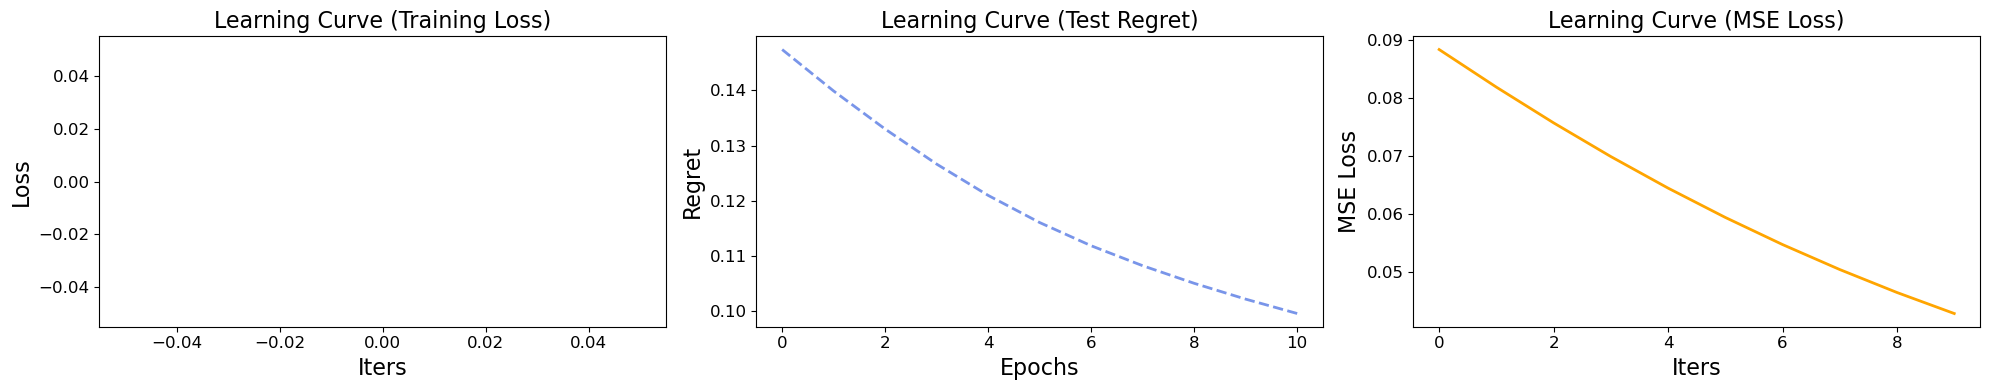

In [94]:

# Set up the model, optimizer, and MSE loss
optmodel = optModel
model = LinearRegressionModel(num_items, num_features).to(device)
# criterion = nn.MSELoss()
criterion = RegretLoss(optModel,Q)

# Run the training
loss_log, loss_log_regret, mse_loss_log = trainModel(model, criterion, num_epochs=10, lr=1e-2)

# Visualize the learning curves
visLearningCurve(loss_log, loss_log_regret, mse_loss_log)

In [95]:
loss_values = [0.1685, 0.2213, 0.2536, 0.2553, 0.3009, 0.2586, 0.2581, 0.3283, 0.1592, 0.2653]
mse_values = [0.0356, 0.0418, 0.0430, 0.0418, 0.0456, 0.0410, 0.0401, 0.0492, 0.0328, 0.0395]
regret_values = [1.7543, 1.7493, 1.7285, 1.7271, 1.7268, 1.7542, 1.7439, 1.7501, 1.7529, 1.7504]

mean_loss = sum(loss_values) / len(loss_values)
mean_mse = sum(mse_values) / len(mse_values)
mean_regret = sum(regret_values) / len(regret_values)

mean_loss, mean_mse, mean_regret

(0.24691000000000002, 0.04104, 1.74375)

## E2E using closed-form solutions w analytical gradient

In [96]:
def closed_form_solution_and_gradient(c, r, Q=Q, alpha=2):
    """
    Compute the closed-form solution d* and its gradient with respect to r.

    Args:
        c (np.ndarray): cost vector
        r (np.ndarray): prediction vector
        Q (float): budget
        alpha (float): parameter alpha

    Returns:
        tuple: optimal solution (d*), gradient of d* with respect to r
    """
    S = np.sum(c ** (1 - 1 / alpha) * r ** (-1 + 1 / alpha))
    d_star = (c ** (-1 / alpha) * r ** (-1 + 1 / alpha) * Q) / S
    
    # Gradient of d* with respect to r
    grad_d_star_r = np.zeros_like(r)
    for i in range(len(r)):
        A_i = c[i] ** (-1 / alpha) * r[i] ** (-1 + 1 / alpha)
        grad_d_star_r[i] = Q * ((-1 + 1 / alpha) * c[i] ** (-1 / alpha) * r[i] ** (-2 + 1 / alpha) * (S - c[i] ** (1 - 1 / alpha) * r[i] ** (-1 + 1 / alpha))) / S**2
    
    return grad_d_star_r

In [97]:
class RegretLossFunction(Function):
    @staticmethod
    def forward(ctx, optmodel, cost, pred_r, true_r, true_obj, Q, alpha):
        batch_size = pred_r.size(0)
        losses = torch.zeros(batch_size, device=pred_r.device)
        
        # Keep tensors within PyTorch
        pred_r_np = pred_r.detach().cpu().numpy()
        true_r_np = true_r.detach().cpu().numpy()
        cost_np = cost.detach().cpu().numpy()
        
        solutions = []  # Save solutions for use in backward pass
        
        for i in range(batch_size):
            # Solve the optimization problem using pred_r
            model = optmodel(pred_r_np[i], cost_np[i], Q, alpha=alpha)
            sol, _ = model.solve()
            solutions.append(sol)
            
            # Calculate the objective with the true reward
            obj = objValue(sol, true_r_np[i], alpha=alpha)

            # Calculate the regret (loss)
            losses[i] = true_obj[i] - obj
        
        # Store necessary tensors for backward pass
        ctx.save_for_backward(pred_r, true_r, cost, true_obj)
        ctx.optmodel = optmodel
        ctx.Q = Q
        ctx.alpha = alpha
        ctx.solutions = solutions  # Save the solutions
        ctx.losses = losses

        return losses.mean()

    @staticmethod
    def backward(ctx, grad_output):
        pred_r, true_r, cost, true_obj = ctx.saved_tensors
        optmodel = ctx.optmodel
        Q = ctx.Q
        alpha = ctx.alpha
        solutions = ctx.solutions

        batch_size = pred_r.size(0)
        grad_pred_r = torch.zeros_like(pred_r)

        epsilon = 1e-5  # Perturbation step size for finite differences
        
        for i in range(batch_size):
            pred_r_np = pred_r[i].detach().cpu().numpy()
            cost_np = cost[i].detach().cpu().numpy()
            true_r_np = true_r[i].detach().cpu().numpy()

            # Analytical gradient of d(rp) w.r.t rp using the provided closed-form formula
            grad_d_star_r = closed_form_solution_and_gradient(cost_np, pred_r_np, Q=Q, alpha=alpha)
            
            # Compute loss with respect to d(rp) by finite differences
            perturbed_grad_loss_d_rp = np.zeros_like(pred_r_np)
            for j in range(pred_r_np.size):
                perturbed_pred_r = np.copy(pred_r_np)
                
                # Solve the optimization problem with perturbed predicted rewards
                model = optmodel(perturbed_pred_r, cost_np, Q, alpha=alpha)
                sol, _ = model.solve()
                
                # Calculate the objective with true rewards
                obj_perturbed = objValue(sol, true_r_np, alpha=alpha) + epsilon
                loss_perturbed = true_obj[i] - obj_perturbed
                
                # Calculate the gradient of the loss with respect to d(rp)
                perturbed_grad_loss_d_rp[j] = (loss_perturbed - ctx.losses[i].item()) / epsilon
            
            # Multiply the gradients: loss/d(rp) * d(rp)/rp
            grad_pred_r[i] = torch.tensor(perturbed_grad_loss_d_rp, device=pred_r.device) * torch.tensor(grad_d_star_r, device=pred_r.device)

        # Scale the gradient by grad_output
        grad_pred_r = grad_output.view(-1, 1) * grad_pred_r

        return None, None, grad_pred_r, None, None, None, None


In [98]:
class RegretLoss(nn.Module):
    def __init__(self, optmodel, Q, alpha=2):
        super(RegretLoss, self).__init__()
        self.optmodel = optmodel
        self.Q = Q
        self.alpha = alpha

    def forward(self, pred_r, true_r, cost, true_obj):
        return RegretLossFunction.apply(self.optmodel, cost, pred_r, true_r, true_obj, self.Q, self.alpha)


In [99]:
def trainModel(predmodel, loss_func, num_epochs=10, lr=1e-2):
    optimizer = torch.optim.Adam(predmodel.parameters(), lr=lr)
    mse_loss_func = nn.MSELoss()  # Fixed MSE loss metric
    predmodel.train()
    
    loss_log = []
    loss_log_regret = [regret(predmodel, optmodel, loader_test)]
    mse_loss_log = []  # New MSE loss log
    elapsed = 0

    for epoch in range(num_epochs):
        tick = time.time()
        for i, data in enumerate(loader_train):
            x, c, r, d, z = data
            if torch.cuda.is_available():
                x, c, r, d, z = x.cuda(), c.cuda(), r.cuda(), d.cuda(), z.cuda()

            optimizer.zero_grad()
            rp = predmodel(x)  # Forward pass

            # Compute the regret loss (original loss)
            loss = loss_func(rp, r, c, z)
            # Compute MSE loss (new fixed metric)
            mse_loss = mse_loss_func(rp, r)

            loss.backward()
            optimizer.step()

            tock = time.time()
            elapsed += tock - tick
            loss_log.append(loss.item())
            mse_loss_log.append(mse_loss.item())  # Log the MSE loss

        # Compute and log the regret loss after each epoch
        regret_loss = regret(predmodel, optmodel, loader_test)
        loss_log_regret.append(regret_loss)
        print(f"Epoch {epoch + 1:2},  Loss: {loss.item():9.4f},  MSE: {mse_loss.item():7.4f},  Regret: {regret_loss * 100:7.4f}%")

    print(f"Total Elapsed Time: {elapsed:.2f} Sec.")
    return loss_log, loss_log_regret, mse_loss_log  # Return MSE loss log as well

In [100]:
loss_values = [0.2013, 0.2832, 0.2789, 0.2269, 0.2599, 0.2390, 0.2486, 0.2124, 0.2820, 0.2145]
mse_values = [0.0550, 0.0968, 0.1182, 0.1125, 0.1657, 0.1758, 0.1789, 0.1588, 0.2185, 0.2130]
regret_values = [2.0833, 1.9421, 1.8039, 1.7280, 1.6959, 1.6801, 1.6727, 1.6686, 1.6665, 1.6651]

mean_loss = sum(loss_values) / len(loss_values)
mean_mse = sum(mse_values) / len(mse_values)
mean_regret = sum(regret_values) / len(regret_values)

mean_loss, mean_mse, mean_regret

(0.24467, 0.14932, 1.7606199999999999)

In [101]:
import numpy as np

# Given values
loss_values_new_epoch = [0.2013, 0.2832, 0.2789, 0.2269, 0.2599, 0.2390, 0.2486, 0.2124, 0.2820, 0.2145]
mse_values_new_epoch = [0.0550, 0.0968, 0.1182, 0.1125, 0.1657, 0.1758, 0.1789, 0.1588, 0.2185, 0.2130]
regret_values_new_epoch = [2.0833, 1.9421, 1.8039, 1.7280, 1.6959, 1.6801, 1.6727, 1.6686, 1.6665, 1.6651]

# Calculate mean and standard deviation
mean_loss_new_epoch = np.mean(loss_values_new_epoch)
mean_mse_new_epoch = np.mean(mse_values_new_epoch)
mean_regret_new_epoch = np.mean(regret_values_new_epoch)

std_loss_new_epoch = np.std(loss_values_new_epoch)
std_mse_new_epoch = np.std(mse_values_new_epoch)
std_regret_new_epoch = np.std(regret_values_new_epoch)

mean_loss_new_epoch, std_loss_new_epoch, mean_mse_new_epoch, std_mse_new_epoch, mean_regret_new_epoch, std_regret_new_epoch

(0.24467000000000003,
 0.029116388855763,
 0.14932,
 0.04975352851808604,
 1.7606199999999999,
 0.1359584480641052)

Epoch  1,  Loss:       nan,  MSE:  0.0750,  Regret:     nan%
Epoch  2,  Loss:       nan,  MSE:     nan,  Regret:     nan%
Epoch  3,  Loss:       nan,  MSE:     nan,  Regret:     nan%
Epoch  4,  Loss:       nan,  MSE:     nan,  Regret:     nan%
Epoch  5,  Loss:       nan,  MSE:     nan,  Regret:     nan%
Epoch  6,  Loss:       nan,  MSE:     nan,  Regret:     nan%
Epoch  7,  Loss:       nan,  MSE:     nan,  Regret:     nan%
Epoch  8,  Loss:       nan,  MSE:     nan,  Regret:     nan%
Epoch  9,  Loss:       nan,  MSE:     nan,  Regret:     nan%
Epoch 10,  Loss:       nan,  MSE:     nan,  Regret:     nan%
Total Elapsed Time: 0.27 Sec.


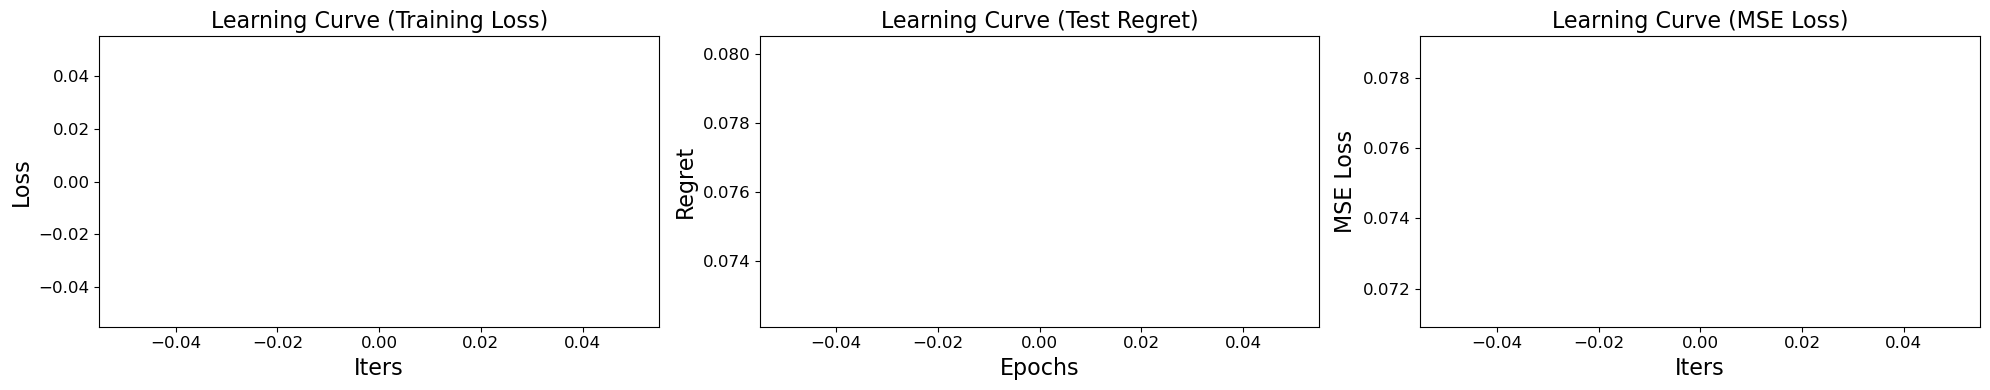

In [102]:
# Set up the model, optimizer, and MSE loss
optmodel = optModelClosed
model = LinearRegressionModel(num_items, num_features).to(device)
# criterion = nn.MSELoss()
criterion = RegretLoss(optmodel,Q)

# Run the training
loss_log, loss_log_regret, mse_loss_log = trainModel(model, criterion, num_epochs=10, lr=1e-2)

# Visualize the learning curves
visLearningCurve(loss_log, loss_log_regret, mse_loss_log)

## E2E using solver on regret loss with KKT Matrix

In [103]:
from scipy.linalg import solve, pinv


# Helper function to check matrix invertibility
def is_invertible(matrix):
    return np.linalg.cond(matrix) < 1 / np.finfo(matrix.dtype).eps

def solve_rd_matrix_system(r, c, d_i, mu, lambda_i, Q=100, alpha=2):
    n = len(r)
    
    # Step 1: Construct Hessian of the objective function (H_dd)
    A_elements = [alpha * r[i]**2 * (r[i] * d_i[i])**(-alpha - 1) for i in range(n)]
    H_dd = np.diag(A_elements)
    
    # Step 2: Construct Jacobians of inequality constraints (g(d;r)) and equality constraints (h(d;r))
    B = -np.eye(n)  # Jacobian of g(d;r) = d >= 0 is -I
    C = c.reshape(-1, 1)  # Jacobian of h(d;r) = sum(c * d) - Q is the vector of c_i's
    
    # Step 3: Construct D and M matrices
    D = np.diag(d_i)  # Diagonal matrix with d_i's
    M = mu * c.reshape(1, -1)  # Row vector of mu * c
    
    # Step 4: Complementary slackness matrix with lambda_i
    if lambda_i.ndim > 2:
        raise ValueError(f"lambda_i has too many dimensions: {lambda_i.ndim}")
    lambda_i = lambda_i.flatten()  # Ensure it's 1-dimensional
    Lambda = np.diag(lambda_i)  # Diagonal matrix from lambda_i
    
    # Step 5: Construct the full block matrix system
    LHS = np.block([
        [H_dd, B, C],  # First row block
        [Lambda, D, np.zeros((n, 1))],  # Second row block
        [M, np.zeros((1, n)), np.array([[np.sum(c * d_i) - Q]])]  # Third row block
    ])
    
    # Step 6: Construct the RHS vector
    v = np.array([-alpha * r[i] * (r[i] * d_i[i])**(-alpha - 1) for i in range(n)])
    RHS = np.hstack([v, np.zeros(n), np.zeros(1)])
    
    # Step 7: Solve the matrix system
    if is_invertible(LHS):
        solution = solve(LHS, RHS)
        d_r_derivatives = solution[:n]
        return d_r_derivatives
    else:
        solution = np.dot(pinv(LHS), RHS)
        return solution[:n]

In [104]:
class optModelMatrix:
    """
    This is a class for optimization models.
    """

    def __init__(self, r, c, Q, alpha=2):
        self.r = r
        self.c = c
        self.Q = Q
        self.alpha = alpha
        self.num_data = num_data
        self.num_items = num_items

        
    def __repr__(self):
        return 'optModel ' + self.__class__.__name__

    def setObj(self, r, c):

        if self.alpha == 1:
            self.objective = cp.sum(cp.log(cp.multiply(r, self.d)))
        else:
            self.objective = cp.sum(cp.power(cp.multiply(r, self.d), 1 - self.alpha)) / (1 - self.alpha)
        
        self.constraints = [
            self.d >= 0,
            cp.sum(cp.multiply(c, self.d)) <= self.Q
        ]
        self.problem = cp.Problem(cp.Maximize(self.objective), self.constraints)


    def solve(self, closed=False):
        """
        A method to solve the optimization problem for one set of parameters.

        Args:
            r (np.ndarray): The r parameter for the optimization
            c (np.ndarray): The c parameter for the optimization
            closed (bool): solving the problem in closed form

        Returns:
            tuple: optimal solution and optimal value
        """
        if closed:
            return self.solveC()

        self.d = cp.Variable(self.num_items)
        self.setObj(self.r, self.c)
        self.problem.solve(abstol=1e-9, reltol=1e-9, feastol=1e-9)
        opt_sol = self.d.value
        opt_val = self.problem.value


        # Dual values for the constraints
        lambdas = self.constraints[0].dual_value
        mus = self.constraints[1].dual_value
    
        return opt_sol, opt_val, lambdas, mus
    
class optDatasetMatrix(Dataset):
    """
    This class is Torch Dataset class for optimization problems.
    """

    def __init__(self, features, costs, r, Q, alpha=2, closed=False):
        """
        A method to create a optDataset from optModel

        Args:
            model (optModel): optimization model
            features (np.ndarray): features
            c (np.ndarray): c of objective function
            r (np.ndarray): r of objective function
            Q (float): budget
            alpha (float): alpha of objective function
            closed (bool): solving the problem in closed form

        """
        self.feats = features
        self.costs = costs
        self.r = r
        self.Q = Q
        self.alpha = alpha
        self.closed = closed
        # Now store the dual values
        self.sols, self.objs, self.lambdas, self.mus = self._getSols()

    def _getSols(self):
        """
        A method to get the solutions and dual values of the optimization problem
        """
        opt_sols = []
        opt_objs = []
        dual_lambdas = []
        dual_mus = []
        
        for i in tqdm(range(len(self.costs))):
            sol, obj, lambdas, mus = self._solve(self.r[i], self.costs[i])
            opt_sols.append(sol)
            opt_objs.append([obj])
            dual_lambdas.append(lambdas)
            dual_mus.append(mus)
            
        return np.array(opt_sols), np.array(opt_objs), np.array(dual_lambdas), np.array(dual_mus)


    def  _solve(self, r, c):
        """
        A method to solve the optimization problem to get oan optimal solution with given r and c

        Args:
            r (np.ndarray): r of objective function
            c (np.ndarray): c of objective function

        Returns:
            tuple: optimal solution (np.ndarray), objective value (float)
        """
        self.model = optModelMatrix(r, c, self.Q, self.alpha)
        if self.closed:
            return self.model.solveC()
        else:
            return self.model.solve()

    def __len__(self):
        """
        A method to get data size

        Returns:
            int: the number of optimization problems
        """
        return len(self.costs)
    
    def __getitem__(self, index):
        return (
            torch.FloatTensor(self.feats[index]),  # x 
            torch.FloatTensor(self.costs[index]),  # c
            torch.FloatTensor(self.r[index]),      # r 
            torch.FloatTensor(self.sols[index]),   # optimal solution
            torch.FloatTensor(self.objs[index]),   # objective value
            torch.FloatTensor(self.lambdas[index]),  # dual value (lambdas)
            torch.FloatTensor([self.mus[index]])     # dual value (mus)
        )

In [105]:
optmodel = optModelMatrix(r, c, Q, alpha=2)

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
x_train, x_test, c_train, c_test, r_train, r_test = train_test_split(x, c, r, test_size=0.2, random_state=42)

# Create datasets and dataloaders
dataset_train = optDatasetMatrix(x_train, c_train, r_train, Q, alpha=2, closed=False)
dataset_test = optDatasetMatrix(x_test, c_test, r_test, Q, alpha=2, closed=False)
batch_size = 32
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

100%|██████████| 16/16 [00:00<00:00, 303.13it/s]


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (16,) + inhomogeneous part.

In [29]:
def regretMatrix(predmodel, optmodel, dataloader):
    """
    A function to evaluate model performance with normalized true regret

    Args:
        predmodel (nn): a regression neural network for cost prediction
        optmodel (optModel): an PyEPO optimization model
        dataloader (DataLoader): Torch dataloader from optDataSet

    Returns:
        float: true regret loss
    """
    # evaluate
    predmodel.eval()
    loss = 0
    optsum = 0
    # load data
    for data in dataloader:
        x, c, r, d, z, _, _  = data
        # cuda
        if next(predmodel.parameters()).is_cuda:
            x, c, r, d, z, dual_lambda, mu = x.cuda(), c.cuda(), r.cuda(), d.cuda(), z.cuda(), _, _
        # predict
        with torch.no_grad(): # no grad
            rp = predmodel(x).to("cpu").detach().numpy()
        # solve
        for j in range(rp.shape[0]):
            # accumulate loss
            loss += calRegretMatrix(optmodel, c[j].to("cpu").detach().numpy(), rp[j], r[j].to("cpu").detach().numpy(),
                              z[j].item())
        optsum += abs(z).sum().item()
    # turn back train mode
    predmodel.train()
    # normalized
    return loss / (optsum + 1e-7)


def calRegretMatrix(optmodel, cost, pred_r, true_r, true_obj):
    """
    A function to calculate normalized true regret for a batch

    Args:
        optmodel (optModel): optimization model
        pred_cost (torch.tensor): predicted costs
        true_cost (torch.tensor): true costs
        true_obj (torch.tensor): true optimal objective values

    Returns:predmodel
        float: true regret losses
    """
    # opt sol for pred cost
    model = optmodel(pred_r, cost, Q, alpha=2)
    sol, _, _, _ = model.solve()
    # obj with true cost
    obj = objValue(sol, true_r, alpha=2)
    # loss
    loss = true_obj - obj
    return loss

In [30]:
def trainModelMatrix(predmodel, loss_func, optmodel, loader_train, loader_test, num_epochs=10, lr=1e-2):
    optimizer = torch.optim.Adam(predmodel.parameters(), lr=lr)
    mse_loss_func = nn.MSELoss()  # Fixed MSE loss metric
    predmodel.train()
    
    loss_log = []
    loss_log_regret = [regretMatrix(predmodel, optmodel, loader_test)]  # Initial regret loss on test set
    mse_loss_log = []  # New MSE loss log
    elapsed = 0

    for epoch in range(num_epochs):
        tick = time.time()
        for i, data in enumerate(loader_train):
            x, c, r, d, z, dual_lambda, mu = data  # Assuming z is true_obj in this case
            if torch.cuda.is_available():
                x, c, r, d, z, dual_lambda, mu = x.cuda(), c.cuda(), r.cuda(), d.cuda(), z.cuda(), dual_lambda.cuda(), mu.cuda()

            optimizer.zero_grad()
            rp = predmodel(x)  # Forward pass

            # Compute the regret loss (original loss)
            loss = loss_func(rp, r, c, z, dual_lambda, mu)
            # Compute MSE loss (new fixed metric)
            mse_loss = mse_loss_func(rp, r)

            loss.backward()
            optimizer.step()

            tock = time.time()
            elapsed += tock - tick
            loss_log.append(loss.item())
            mse_loss_log.append(mse_loss.item())  # Log the MSE loss

        # Compute and log the regret loss after each epoch
        regret_loss = regretMatrix(predmodel, optmodel, loader_test)
        loss_log_regret.append(regret_loss)
        print(f"Epoch {epoch + 1:2},  Loss: {loss.item():9.4f},  MSE: {mse_loss.item():7.4f},  Regret: {regret_loss * 100:7.4f}%")

    print(f"Total Elapsed Time: {elapsed:.2f} Sec.")
    return loss_log, loss_log_regret, mse_loss_log  # Return MSE loss log as well


In [31]:
import torch
from torch.autograd import Function
import torch.nn as nn

class RegretLossMatrix(nn.Module):
    def __init__(self, optmodel, Q, alpha=2):
        super(RegretLossMatrix, self).__init__()
        self.optmodel = optmodel
        self.Q = Q
        self.alpha = alpha

    def forward(self, pred_r, true_r, cost, true_obj, dual_lambda, mu):
        return RegretLossFunctionMatrix.apply(self.optmodel, dual_lambda, mu, cost, pred_r, true_r, true_obj, self.Q, self.alpha)


class RegretLossFunctionMatrix(Function):
    @staticmethod
    def forward(ctx, optmodel, dual_lambda, mu, cost, pred_r, true_r, true_obj, Q, alpha):
        batch_size = pred_r.size(0)
        losses = torch.zeros(batch_size, device=pred_r.device)
        
        # Keep tensors within PyTorch
        pred_r_np = pred_r.detach().cpu().numpy()
        true_r_np = true_r.detach().cpu().numpy()
        cost_np = cost.detach().cpu().numpy()
        dual_lambda_np = dual_lambda.detach().cpu().numpy()
        mu_np = mu.detach().cpu().numpy()
        
        solutions = []  # Save solutions for use in backward pass
        
        for i in range(batch_size):
            # Solve the optimization problem using pred_r
            model = optmodel(pred_r_np[i], cost_np[i], Q, alpha=alpha)
            sol, _, _, _ = model.solve()
            solutions.append(sol)
            
            # Calculate the objective with the true reward
            obj = objValue(sol, true_r_np[i], alpha=alpha)

            # Calculate the regret (loss)
            losses[i] = true_obj[i] - obj
        
        # Store necessary tensors for backward pass
        ctx.save_for_backward(pred_r, true_r, cost, true_obj, dual_lambda, mu)
        ctx.optmodel = optmodel
        ctx.Q = Q
        ctx.alpha = alpha
        ctx.solutions = solutions  # Save the solutions
        ctx.losses = losses

        return losses.mean()

    @staticmethod
    def backward(ctx, grad_output):
        pred_r, true_r, cost, true_obj, dual_lambda, mu = ctx.saved_tensors
        optmodel = ctx.optmodel
        Q = ctx.Q
        alpha = ctx.alpha
        solutions = ctx.solutions

        batch_size = pred_r.size(0)
        grad_pred_r = torch.zeros_like(pred_r)

        epsilon = 1e-5  # Perturbation step size for finite differences
        
        for i in range(batch_size):
            pred_r_np = pred_r[i].detach().cpu().numpy()
            cost_np = cost[i].detach().cpu().numpy()
            true_r_np = true_r[i].detach().cpu().numpy()
            lambda_np = dual_lambda[i].detach().cpu().numpy()
            mu_np = mu[i].detach().cpu().numpy()
            solution_np = solutions[i]

            # Analytical gradient of d(rp) w.r.t rp using the provided closed-form formula
            grad_d_star_r = solve_rd_matrix_system(pred_r_np, cost_np, solution_np, mu_np, lambda_np)
                # Check if the result is a dictionary (which indicates an error like matrix non-invertibility)
            if isinstance(grad_d_star_r, dict) and "error" in grad_d_star_r:
                print(f"Warning: {grad_d_star_r['error']}. Skipping this sample.")
                continue  # Skip this batch if there's an error


            # Compute loss with respect to d(rp) by finite differences
            perturbed_grad_loss_d_rp = np.zeros_like(pred_r_np)
            for j in range(pred_r_np.size):
                perturbed_pred_r = np.copy(pred_r_np)
                
                # Solve the optimization problem with perturbed predicted rewards
                model = optmodel(perturbed_pred_r, cost_np, Q, alpha=alpha)
                sol, _, _, _ = model.solve()
                
                # Calculate the objective with true rewards
                obj_perturbed = objValue(sol, true_r_np, alpha=alpha) + epsilon
                loss_perturbed = true_obj[i] - obj_perturbed
                
                # Calculate the gradient of the loss with respect to d(rp)
                perturbed_grad_loss_d_rp[j] = (loss_perturbed - ctx.losses[i].item()) / epsilon
            
            # Multiply the gradients: loss/d(rp) * d(rp)/rp
            grad_pred_r[i] = torch.tensor(perturbed_grad_loss_d_rp, device=pred_r.device) * torch.tensor((grad_d_star_r*-1), device=pred_r.device)

        # Scale the gradient by grad_output
        grad_pred_r = grad_output.view(-1, 1) * grad_pred_r

        return None, None, None, None, grad_pred_r, None, None, None, None



Epoch  1,  Loss:    0.3135,  MSE:  0.0731,  Regret:  1.9558%
Epoch  2,  Loss:    0.3485,  MSE:  0.0921,  Regret:  1.9539%
Epoch  3,  Loss:    0.3279,  MSE:  0.1424,  Regret:  1.9602%
Epoch  4,  Loss:    0.2857,  MSE:  0.1900,  Regret:  1.9281%
Epoch  5,  Loss:    0.2262,  MSE:  0.2811,  Regret:  1.9572%
Epoch  6,  Loss:    0.2472,  MSE:  0.2751,  Regret:  1.9095%
Epoch  7,  Loss:    0.2151,  MSE:  0.2793,  Regret:  1.9451%
Epoch  8,  Loss:    0.3322,  MSE:  0.2944,  Regret:  1.8699%
Epoch  9,  Loss:    0.2457,  MSE:  0.3170,  Regret:  1.9518%
Epoch 10,  Loss:    0.1750,  MSE:  0.3592,  Regret:  1.8787%
Total Elapsed Time: 10100.17 Sec.


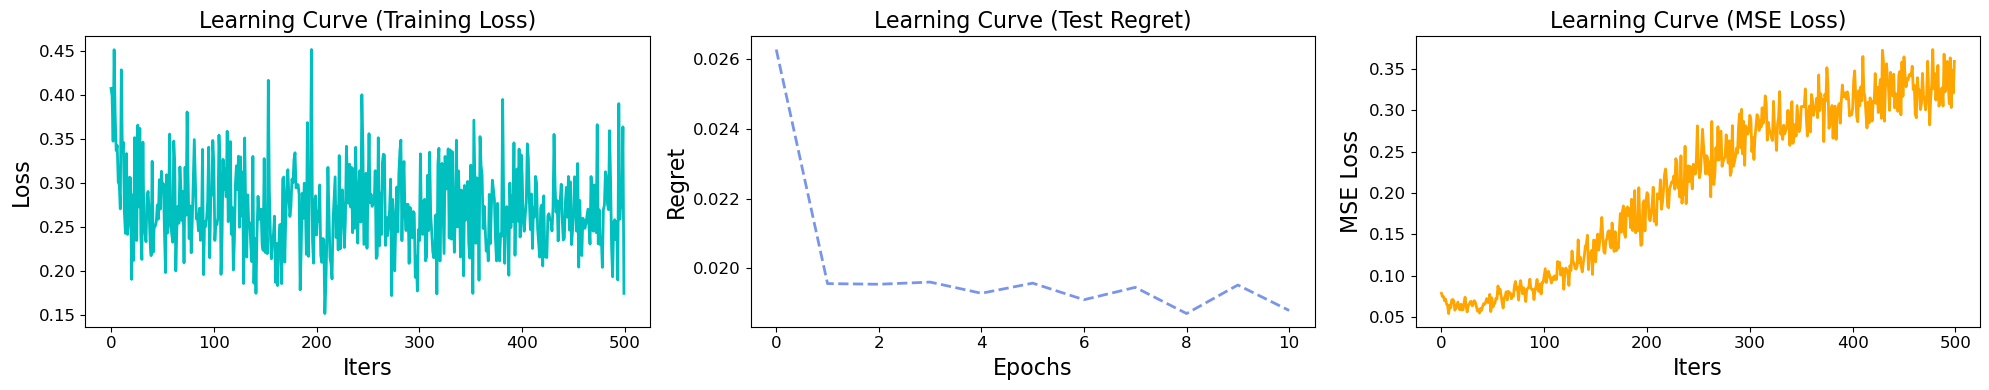

In [32]:
# Set up the model, optimizer, and MSE loss
optmodel = optModelMatrix
model = LinearRegressionModel(num_items, num_features).to(device)
# criterion = nn.MSELoss()
criterion = RegretLossMatrix(optmodel,Q)

# Run the training
loss_log, loss_log_regret, mse_loss_log = trainModelMatrix(model, criterion, optmodel, loader_train, loader_test, num_epochs=10, lr=1e-2)

# Visualize the learning curves
visLearningCurve(loss_log, loss_log_regret, mse_loss_log)

In [5]:
import numpy as np

# Given values
loss_values = [0.3135, 0.3485, 0.3279, 0.2857, 0.2262, 0.2472, 0.2151, 0.3322, 0.2457, 0.1750]
mse_values = [0.0731, 0.0921, 0.1424, 0.1900, 0.2811, 0.2751, 0.2793, 0.2944, 0.3170, 0.3592]
regret_values = [1.9558, 1.9539, 1.9602, 1.9281, 1.9572, 1.9095, 1.9451, 1.8699, 1.9518, 1.8787]

# Calculate mean and standard deviation
mean_loss = np.mean(loss_values)
mean_mse = np.mean(mse_values)
mean_regret = np.mean(regret_values)

std_loss = np.std(loss_values)
std_mse = np.std(mse_values)
std_regret = np.std(regret_values)

mean_loss, std_loss, mean_mse, std_mse, mean_regret, std_regret

(0.27169999999999994,
 0.05528211283950713,
 0.23037000000000002,
 0.09401655226607705,
 1.9310199999999997,
 0.03201427181742544)